<a href="https://www.kaggle.com/code/alyeko/segmentation-of-floodwater-s2data?scriptVersionId=112367399" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Work in progress!!!

This notebook is my attempt at:
1. Creating a Pytorch dataset class (with useful methods) from scratch 
2. Implementing a UNET segmentation model for segmenting floodwater from Sentinel-2 Optical Satellite Imagery

In [ ]:
Contents

### Installing and importing packages

In [1]:
!pip install radiant_mlhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.1/146.1 kB 3.6 MB/s eta 0:00:0000:01


In [2]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 6.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c9f802c180b962bd3016fb32790d9e74d9933e41f7a0c88f59c6dcc3f8086473
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=36de09871417d4ed5f12b6006ff4501d51d79b2d27e0b5d5b8a078417b4e7ec6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import cv2
import json
import time
import torch
import shutil
import pyproj
import rasterio
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from pathlib import Path
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.transforms as T
# from pystac_client import Client
from matplotlib import pyplot as plt
from radiant_mlhub import Collection 
from torchmetrics import JaccardIndex
from torchvision.utils import make_grid 
# from tempfile import TemporaryDirectory
from shapely.geometry import box, mapping
from rasterio.plot import show, show_hist
from IPython.display import clear_output
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler
from rasterio.warp import reproject, Resampling
from radiant_mlhub import Dataset as mlhubDataset
from torchvision.transforms.functional import resize
from torch.utils.data import Dataset, DataLoader, sampler

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
os.environ['MLHUB_API_KEY'] = 'db46eac832daad6c7169be58fedac9c5f647e704936475ba6df8a0d33e04acc4'

In [6]:
ds = mlhubDataset.fetch('c2smsfloods_v1')
collection_ids = []
for c in ds.collections:
    collection_ids.append(c.id)
    print(c.id)

print('\n', collection_ids)

c2smsfloods_v1_source_s2
c2smsfloods_v1_labels_s2_water
c2smsfloods_v1_labels_s2_cloud
c2smsfloods_v1_source_s1
c2smsfloods_v1_labels_s1_water

 ['c2smsfloods_v1_source_s2', 'c2smsfloods_v1_labels_s2_water', 'c2smsfloods_v1_labels_s2_cloud', 'c2smsfloods_v1_source_s1', 'c2smsfloods_v1_labels_s1_water']


In [7]:
print(f'There are {len(collection_ids)} collections in the datasource')

There are 5 collections in the datasource


In [8]:
collection_ids

['c2smsfloods_v1_source_s2',
 'c2smsfloods_v1_labels_s2_water',
 'c2smsfloods_v1_labels_s2_cloud',
 'c2smsfloods_v1_source_s1',
 'c2smsfloods_v1_labels_s1_water']

### Downloading the data

In [9]:
downloads_path = '/kaggle'
for cid in collection_ids:
    #Collection.fetch(cid).download(f'{downloads_path}/Data') 
    lcollection = Collection.fetch(cid)
    lcollection.download(f'{downloads_path}/Data')

  0%|          | 0/3272.9 [00:00<?, ?M/s]

  0%|          | 0/7.6 [00:00<?, ?M/s]

  0%|          | 0/6.5 [00:00<?, ?M/s]

  0%|          | 0/2037.5 [00:00<?, ?M/s]

  0%|          | 0/6.4 [00:00<?, ?M/s]

In [13]:
downloaded = os.listdir(Path(downloads_path)/'Data')
downloaded

['c2smsfloods_v1_labels_s1_water.tar.gz',
 'c2smsfloods_v1_source_s1.tar.gz',
 'c2smsfloods_v1_labels_s2_water.tar.gz',
 'c2smsfloods_v1_source_s2.tar.gz',
 'c2smsfloods_v1_labels_s2_cloud.tar.gz']

### Extracting the data

In [14]:
for download in downloaded:
    shutil.unpack_archive(f'{downloads_path}/Data/{download}', f'{downloads_path}/Extracted')

In [15]:
for j in os.listdir(Path(downloads_path)/'Extracted'):
    with open(f"{downloads_path}/Extracted/{j}/collection.json", 'r') as j:
        contents = json.loads(j.read())
        print(len(contents['links']))

902
902
902
902
902


In [16]:
downloads_path

'/kaggle'

In [17]:
for j in os.listdir(Path(downloads_path)/'Extracted'):
    print(j)

c2smsfloods_v1_labels_s2_water
c2smsfloods_v1_source_s1
c2smsfloods_v1_labels_s1_water
c2smsfloods_v1_labels_s2_cloud
c2smsfloods_v1_source_s2


### Filepaths to be used in the classes defined below

In [18]:
#1
labels_path1 = f"{downloads_path}/Extracted/c2smsfloods_v1_labels_s1_water" #label files
sources_path1 = f"{downloads_path}/Extracted/c2smsfloods_v1_source_s1"      #source image files

#2
labels_path2 = f"{downloads_path}/Extracted/c2smsfloods_v1_labels_s2_water" #label files
sources_path2 = f"{downloads_path}/Extracted/c2smsfloods_v1_source_s2"      #source image files
cloud_path2 = f"{downloads_path}/Extracted/c2smsfloods_v1_labels_s2_cloud"   #source image files
 

### Data exploration and visualizations

for file in os.listdir(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}"):
    if file.endswith('.tif'):
        image = Image.open(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}/VH.tif")
plt.imshow(np.array(image))
plt.show()

for file in os.listdir(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}"):
    if file.endswith('.tif'):
        image = Image.open(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}/VV.tif")
plt.imshow(np.array(image))
plt.show()

for file in os.listdir(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}"):
    if file.endswith('.png'):
        image = Image.open(f"{sources_path1}/{sorted(os.listdir(sources_path1))[500]}/{file}")
plt.imshow(np.array(image))
plt.show()

In [19]:
sp1 = sorted(os.listdir(sources_path1))
sp1.remove(sp1[-1])
len(sp1)

900

In [20]:
print(sp1[899])
print(sp1.index('c2smsfloods_v1_source_s1_99'))

c2smsfloods_v1_source_s1_99
899


f"{sources_path1}/{sorted(os.listdir(sources_path1))[0]}"

source_images_s1 = []
filesss =[]
for root, dirs, files in os.walk(sources_path1):
    for file in files:
            source_images_s1.append(root)
            filesss.append(file)

In [21]:
print(labels_path2)
print(cloud_path2)

/kaggle/Extracted/c2smsfloods_v1_labels_s2_water
/kaggle/Extracted/c2smsfloods_v1_labels_s2_cloud


In [22]:
os.listdir(f'{cloud_path2}/c2smsfloods_v1_labels_s2_cloud_734')  #kaggle/Extracted/c2smsfloods_v1_labels_s2_cloud/c2smsfloods_v1_labels_s2_cloud_734/labels.tif'}]
#c2smsfloods_v1_labels_s2_water_734

['stac.json', 'labels.tif', 'LabelCloud.png']

In [23]:
print(sorted([b for b in os.listdir(f"{labels_path2}/{os.listdir(labels_path2)[0]}")]))
print(sorted([b for b in os.listdir(f"{cloud_path2}/{os.listdir(cloud_path2)[0]}")]))

['LabelWater.png', 'labels.tif', 'stac.json']
['LabelCloud.png', 'labels.tif', 'stac.json']


pthh = f'{labels_path2}//{os.listdir(labels_path2)[734]}'
pthh

yk.min()

y = np.array(Image.open(f'{pthh}/LabelWater.png'))
yk = ((y- (np.iinfo(y.dtype).min))/((np.iinfo(y.dtype).max)-(np.iinfo(y.dtype).min)))
yk

In [ ]:
plt.imshow(np.array(Image.open(f'{pthh}/LabelWater.png'))[:, :, :3])

In [ ]:
ras = rasterio.open(f'{pthh}/labels.tif')
plt.imshow(ras.read(1))

In [32]:
j = np.arange(0, 4)
j.max()

3

In [26]:
class FloodDataset(Dataset): #class modified and adapted from https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf
        def __init__(self, source_path, labels_path, sentinel1=True, cloud_label=False, pytorch=True):  #and https://drivendata.co/blog/detect-floodwater-benchmark
            
            super().__init__()
            self.source_path = source_path
            self.labels_path = labels_path
            self.sentinel1 = sentinel1
            self.pytorch = pytorch
            self.cloud_label = cloud_label

            self.source_images = sorted(os.listdir(self.source_path))#[:735]
            self.labels = sorted(os.listdir(self.labels_path))#[:735]

            self.to_drop = ['collection.json', '_common']
            for i in self.to_drop:
                if i in self.labels:
                    self.labels.remove(i)
                if i in self.source_images:
                    self.source_images.remove(i)

            self.files = [self.extract_files(self.source_path, self.labels_path, self.sentinel1, num) for num in range(len(self.source_images))]
        
        
        def extract_files(self, source_path, labels_path, sentinel1, num):
            if sentinel1:
                fps = {'VV': f'{source_path}/c2smsfloods_v1_source_s1_{num}/VV.tif',
                       'VH': f'{source_path}/c2smsfloods_v1_source_s1_{num}/VH.tif',
                       'water_mask': f'{labels_path}/c2smsfloods_v1_labels_s1_water_{num}/labels.tif'} 
            else:
                cloud_path = '/kaggle/Extracted/c2smsfloods_v1_labels_s2_cloud'
                fps = {'B1': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B1.tif',
                       'B2': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B2.tif',
                       'B3': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B3.tif',
                       'B4': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B4.tif',
                       'B5': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B5.tif',
                       'B6': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B6.tif',
                       'B7': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B7.tif',
                       'B8': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B8.tif',
                       'B8A': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B8A.tif',
                       'B9': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B9.tif',
                       'B10': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B10.tif',
                       'B11': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B11.tif',
                       'B12': f'{source_path}/c2smsfloods_v1_source_s2_{num}/B12.tif', 
                       'rgb': f'{source_path}/c2smsfloods_v1_source_s2_{num}/RGB.png', 
                       # 'CIR.png',
                       # 'RGB.png',
                       # 'SWIR.png',
                       # 'SWIRP.png',
                       'water_mask': f'{labels_path}/c2smsfloods_v1_labels_s2_water_{num}/labels.tif', 
                       'cloud_mask': f'{cloud_path}/c2smsfloods_v1_labels_s2_cloud_{num}/labels.tif', }
#                        'water_mask': f'{labels_path}/c2smsfloods_v1_labels_s2_water_{num}/LabelWater.png', 
#                        'cloud_mask': f'{cloud_path}/c2smsfloods_v1_labels_s2_cloud_{num}/LabelCloud.png', } 
                                                    
            return fps   
    
    
        def __len__(self):
            try:
                assert len(self.source_images) == len(self.labels)
                len_files = len(self.source_images) #also you might want to check that source filepaths are equal to label filepaths
            except Exception as e:
                print(e)

            return len(self.source_images) #or len(self.files)

        
        def open_radar_as_array(self, idx, VV=True, VH=False, invert=True):
            VV_arr = np.array(Image.open(self.files[idx]['VV']))
            VH_arr = np.array(Image.open(self.files[idx]['VH']))

            if VV:
                arr = np.array(Image.open(self.files[idx]['VV']))
                #arr = arr.transpose((2, 1, 0))

            if VH:
                arr = np.array(Image.open(self.files[idx]['VH']))
                #arr = arr.transpose((2, 1, 0))

            if (VV and VH):
                arr = raw_rgb = np.concatenate([VV_arr, VH_arr], axis=2)
                #arr = arr.transpose((2, 1, 0))

            return arr

        
        def open_radar_mask(self, idx, add_dims=False):
            mask = np.array(Image.open(self.files[idx]['water_mask']))
            return mask

            #raw_mask = np.where(raw_mask==255, 1, 0)
            #return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

            
        def open_optical_as_array(self, idx, rgb=True):#, array=False):
            if rgb:
                arr = np.array(Image.open(self.files[idx]['rgb']))
                #arr = (arr-arr.min())/(arr.max()-arr.min())
                arr = arr.transpose(2, 0, 1)
                
#             else:
#                 #try:
#                     raw_rgb = np.dstack([np.array(Image.open(self.files[idx]['B2'])),
#                                          np.array(Image.open(self.files[idx]['B3'])),
#                                          np.array(Image.open(self.files[idx]['B4']))])
#                     arr = raw_rgb.transpose(2, 0, 1)
                    #arr = raw_rgb/raw_rgb.max()
                #except:
                #if array is false raise exception
             
            return (arr - (np.iinfo(arr.dtype).min)) / ((np.iinfo(arr.dtype).max) - (np.iinfo(arr.dtype).min))
            #return (arr / np.iinfo(arr.dtype).max)
        
        def open_optical_mask(self, idx, add_dims=False):
            water = rasterio.open(self.files[idx]['water_mask'])
            water_mask = water.read(1)
            water_maskk = water_mask/water_mask.max()
            
            cloud = rasterio.open(self.files[idx]['cloud_mask'])
            cloud_mask = cloud.read(1)
            #cloud_mask = (cloud_mask-cloud_mask.min())/(cloud_mask.max()-cloud_mask.min())
            #mask = np.dstack([water_mask, cloud_mask])
            #return [water_mask, cloud_mask]
            return water_maskk
    
            #raw_mask = np.where(raw_mask==255, 1, 0)
            #return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

            
        def __getitem__(self, idx): #think some more about what you want to return here
            if self.sentinel1:
#                 x = torch.tensor(self.open_radar_as_array(idx, VV=True, VH=False, invert=self.pytorch), dtype=torch.float32) #VH=True and see what gets returned
#                 y = torch.tensor(self.open_radar_mask(idx, add_dims=False), dtype=torch.torch.int64)

                  x = torch.tensor(self.create_false_color_composite(idx), dtype=torch.float32)
                  y = torch.tensor(self.open_radar_mask(idx, add_dims=False), dtype=torch.torch.int64)
            else:  #remember to normalize this as well...
                #transform = T.Resize(size = (128))
                        
                x = torch.tensor(self.open_optical_as_array(idx, rgb=True), dtype=torch.float32) #array=False)
                y = torch.tensor(self.open_optical_mask(idx, add_dims=False), dtype=torch.torch.int64)
                
                return x, y

        
        def open_as_pil(self, idx):
            arr = 256*self.open_as_array(idx)

            return Image.fromarray(arr.astype(np.uint8), 'RGB')

        
        def scale_img(self, matrix):  #is there a simpler way to do this???
            """
            Returns a scaled (H, W, C) image that is visually inspectable.
            Image is linearly scaled between min_ and max_value, by channel.

            Args:
                matrix (np.array): (H, W, C) image to be scaled

            Returns:
                np.array: Image (H, W, 3) ready for visualization
            """

            # Setting min/max values
            min_values = np.array([-23, -28, 0.2])
            max_values = np.array([0, -5, 1])

            # Reshaping matrix
            w, h, c = matrix.shape
            matrix = np.reshape(matrix, [w * h, c]).astype(np.float64)

            # Scaling by min/max
            matrix = (matrix - min_values[None, :]) / (max_values[None, :] - min_values[None, :])
            matrix = np.reshape(matrix, [w, h, c])

            # Limit values to 0/1 interval
            return matrix.clip(0, 1)

        
        def create_false_color_composite(self, idx):
            if self.sentinel1:
                with rasterio.open(self.files[idx]['VV']) as vv:
                    vv_img = vv.read(1)
                with rasterio.open(self.files[idx]['VH']) as vh:
                    vh_img = vh.read(1)

                # Stack arrays along the last dimension
                vvvh = np.stack((vv_img, vh_img), axis=-1)

                # Create false color composite
                img = np.zeros((512, 512, 3), dtype=np.float32)
                img[:, :, :2] = vvvh.copy()
                img[:, :, 2]  = vvvh[:, :, 0] / vvvh[:, :, 1]
                
            else: #when sentinel2 datapaths are passed
                pass

            return self.scale_img(img).transpose(2, 0, 1)

        
        def show_radar_and_label(self, idx): #function name should change, should be both radar and optical... thats why you have both if and else
            fig, ax = plt.subplots(1, 2, figsize=(9, 9))
            
            if self.sentinel1:
                false_colour = self.create_false_color_composite(idx)
                
            else:
                pass
                #what is the false colour for sentinel2?
        
            ax[0].imshow(false_colour)   #Visualize features
            ax[0].set_title("False_colour", fontsize=14)
            
            with rasterio.open(self.files[idx]['water_mask']) as lp: #Load water mask
                lp_img = lp.read(1)
            label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)  # Mask missing data and 0s for visualization
            
            ax[1].imshow(false_colour)  # Visualize water label
            ax[1].imshow(label, cmap="cool", alpha=1)
            ax[1].set_title("false_colour with Water Label", fontsize=14)

            plt.tight_layout(pad=5)
            plt.show()
            
            
        def get_name_of_idx(self, idx):
            source_name = self.source_images[idx] 
            label_name = self.labels[idx]

            return f"Source_name: {source_name} Label name: {label_name}"

        
        def __repr__(self):
            s = 'Dataset class with {} files'.format(self.__len__())
            return s

        def create_dataframe(self, ):
            try:
                pass
            except:
                #raise exception error that only sentinel1 data can be created as df for now... check if sentinel1 argument is True or False
                pass


### Obtaining Sentinel 2 data using the FloodDataset class

In [27]:
data_s2 = FloodDataset(source_path=sources_path2, labels_path=labels_path2, sentinel1=False, cloud_label=True, pytorch=True)
print(f'{len(data_s2)}\n')
print(data_s2)

900

Dataset class with 900 files


In [28]:
x, y = data_s2[734]
x.shape, y.shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [29]:
# plt.imshow(data_s1[899][0][0, :, :])
print(data_s2[899][0].min(), data_s2[899][0].max())
print(data_s2[899][1].min(), data_s2[899][1].max())#long())

tensor(0.1216) tensor(1.)
tensor(0) tensor(1)


In [36]:
len(data_s2[899])

2

In [41]:
x, y = data_s2[250]
print(x.shape, y.shape)
print(x.max())
print(y.max())

torch.Size([3, 512, 512]) torch.Size([512, 512])
tensor(1.)
tensor(1)


2


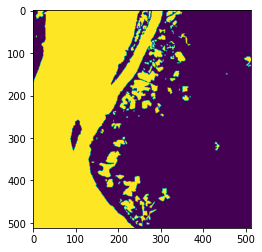

In [42]:
plt.imshow(y)
print(y.ndim)

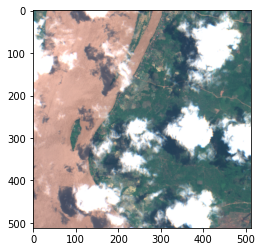

In [43]:
plt.imshow(x.permute(1, 2, 0))

print(data_s2.open_optical_mask(899)[0].shape)
data_s2.open_optical_mask(899)[1].shape

### Creating dataloaders for sentinel1 radar data

In [32]:
#Train, valid, test in the ratio 70:20:10
n_train = len(data_s2) * 0.7
n_valid = len(data_s2) * 0.2
n_test  = len(data_s2) * 0.1
12
print(f"{n_train}\n{n_valid}\n{n_test}\n")

train_ds, valid_ds, test_ds = torch.utils.data.random_split(data_s2, (int(n_train),int(n_valid), int(n_test))) #whhat about a random seed here?

train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=12, shuffle=False)

print(f"{train_dl}\n{valid_dl}\n{test_dl}\n")
print(f"{len(train_dl)}\n{len(valid_dl)}\n{len(test_dl)}")

630.0
180.0
90.0


53
15
8


In [41]:
len(train_dl.dataset)

630

In [32]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 3, 512, 512]), torch.Size([32, 512, 512]))

In [36]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where(~valid_pixel_mask, 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

----------------

In [35]:
""" Parts of the U-Net model """ #adapted from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
#https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [36]:
unet = UNet(3, 2)
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

-------------------

torch.Size([3, 512, 512])


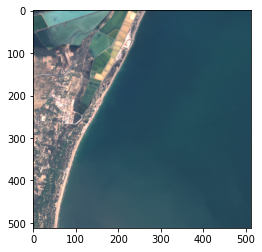

In [37]:
x_img = xb[2, :, :, :]
plt.imshow(x_img.permute(1, 2, 0))
print(x_img.shape)

In [38]:
x_img.min(), x_img.max()

(tensor(0.1216), tensor(1.))

In [39]:
yb[2, :, :].min(), yb[2, :, :].max()

(tensor(0), tensor(1))

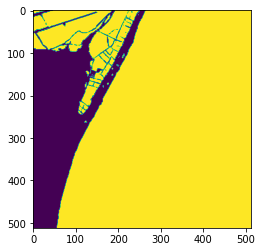

In [40]:
plt.imshow(yb[2, :, :])

In [ ]:
pred = unet(xb)  #Returns the output shape we are expecting
pred.shape

In [ ]:
pred[2, :, :, :].max(), pred[2, :, :, :].min()

In [43]:
pred.shape

torch.Size([32, 2, 512, 512])

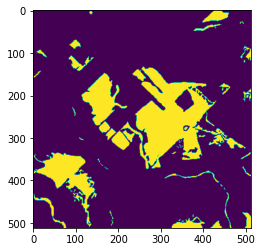

In [44]:
plt.imshow(yb[2, :, :])

In [45]:
def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

#predb = unet(xb)#.cuda())
predb_to_mask(pred, 2)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 1, 1]])

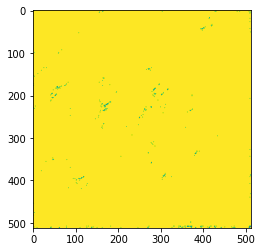

In [46]:
plt.imshow(predb_to_mask(pred, 2))

inn = pred[1, :, :, :]
print(inn.shape)
plt.imshow(inn.permute(1, 2, 0).detach().numpy())
#plt.imshow(pred[1, 0, :, :].detach().numpy())

In [ ]:
# plt.imshow(pred[1, 0, :, :].detach().numpy())
pred[1, 0, :, :].detach().numpy().min()

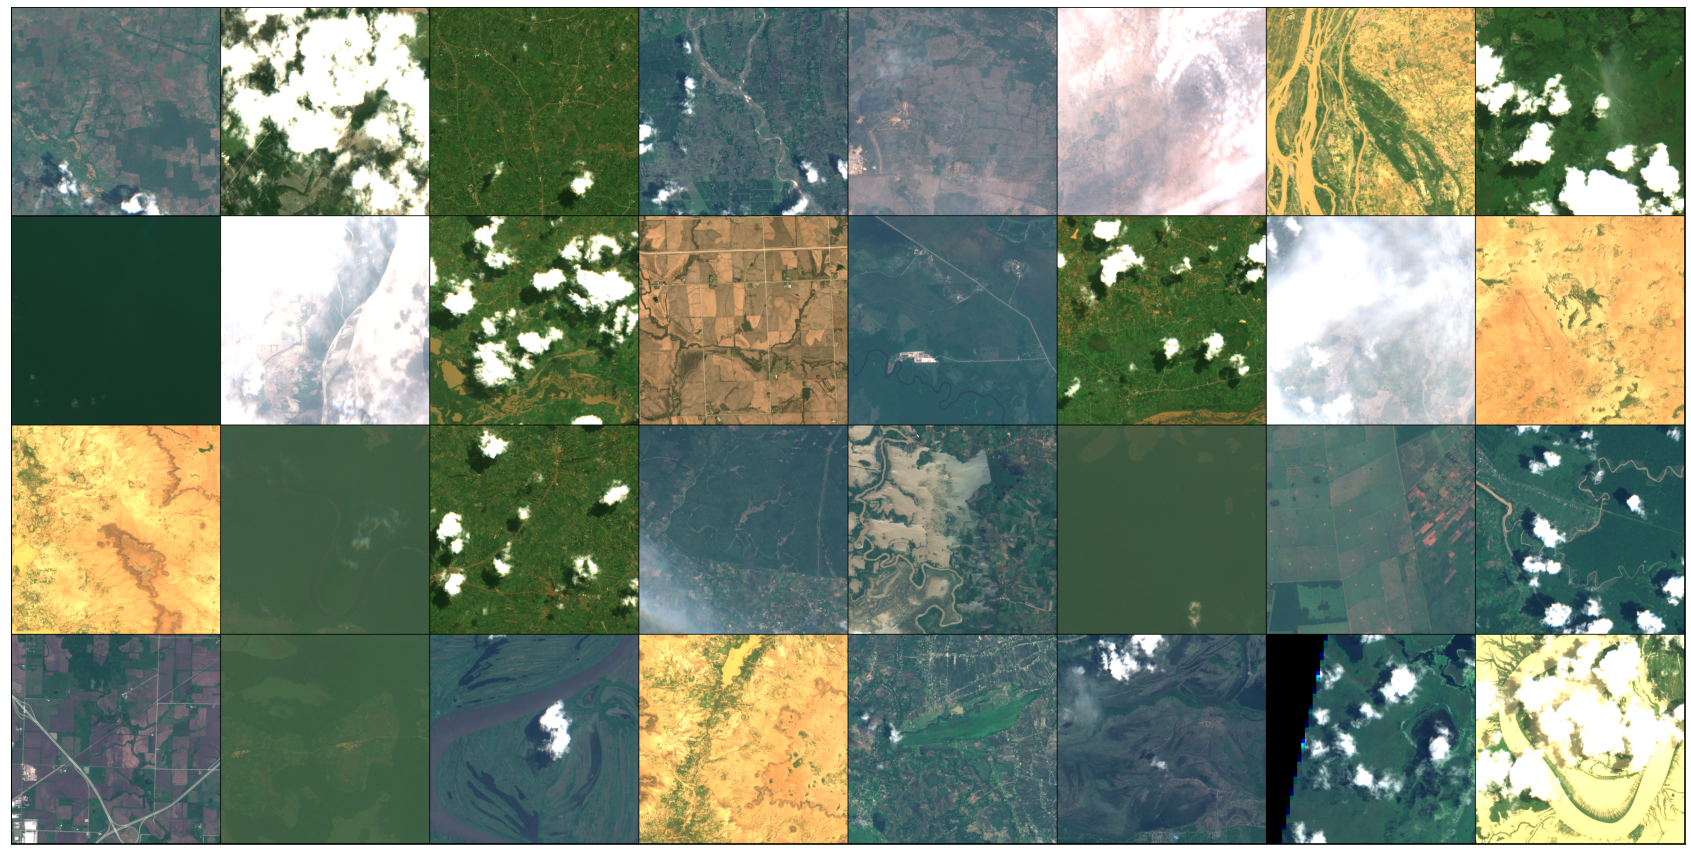

In [43]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
# Images for first batch of training
show_batch(train_dl) 

#the np.iinfo difference, how is it different from a normal scaling calculation
the x and y dtypes that we added to the getitem method

fig, ax = plt.subplots(1, 3, figsize=(10, 9))
ax[0].imshow(data_s2.open_optical_as_array(200, rgb=True, array=False))
ax[1].imshow(data_s2.open_optical_mask(200)[0])
ax[2].imshow(data_s2.open_optical_mask(200)[1])

----------------------------

### UNet model and training 

In [33]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [34]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [35]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [37]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dl))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = fit(epoch, model, 
              train_loader=train_dl, 
              val_loader=valid_dl,
              criterion=criterion,
              optimizer=optimizer,
              scheduler=sched)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.397 
Epoch:1/15.. Train Loss: 0.537.. Val Loss: 0.397.. Train mIoU:0.416.. Val mIoU: 0.504.. Train Acc:0.655.. Val Acc:0.730.. Time: 1.05m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.397 >> 0.265 
Epoch:2/15.. Train Loss: 0.337.. Val Loss: 0.265.. Train mIoU:0.544.. Val mIoU: 0.528.. Train Acc:0.765.. Val Acc:0.771.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 0.315.. Val Loss: 0.337.. Train mIoU:0.514.. Val mIoU: 0.551.. Train Acc:0.757.. Val Acc:0.771.. Time: 0.86m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.337 >> 0.253 
Epoch:4/15.. Train Loss: 0.301.. Val Loss: 0.253.. Train mIoU:0.549.. Val mIoU: 0.570.. Train Acc:0.769.. Val Acc:0.772.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.253 >> 0.206 
saving model...
Epoch:5/15.. Train Loss: 0.274.. Val Loss: 0.206.. Train mIoU:0.574.. Val mIoU: 0.604.. Train Acc:0.782.. Val Acc:0.794.. Time: 0.88m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 0.270.. Val Loss: 0.208.. Train mIoU:0.569.. Val mIoU: 0.610.. Train Acc:0.779.. Val Acc:0.795.. Time: 0.86m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/15.. Train Loss: 0.281.. Val Loss: 0.242.. Train mIoU:0.564.. Val mIoU: 0.514.. Train Acc:0.778.. Val Acc:0.772.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.242 >> 0.210 
Epoch:8/15.. Train Loss: 0.278.. Val Loss: 0.210.. Train mIoU:0.564.. Val mIoU: 0.629.. Train Acc:0.773.. Val Acc:0.788.. Time: 0.88m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.210 >> 0.183 
Epoch:9/15.. Train Loss: 0.231.. Val Loss: 0.183.. Train mIoU:0.627.. Val mIoU: 0.645.. Train Acc:0.794.. Val Acc:0.798.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.183 >> 0.161 
Epoch:10/15.. Train Loss: 0.217.. Val Loss: 0.161.. Train mIoU:0.647.. Val mIoU: 0.669.. Train Acc:0.803.. Val Acc:0.807.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.161 >> 0.158 
Epoch:11/15.. Train Loss: 0.203.. Val Loss: 0.158.. Train mIoU:0.665.. Val mIoU: 0.655.. Train Acc:0.807.. Val Acc:0.809.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.158 >> 0.152 
saving model...
Epoch:12/15.. Train Loss: 0.190.. Val Loss: 0.152.. Train mIoU:0.676.. Val mIoU: 0.672.. Train Acc:0.812.. Val Acc:0.810.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.152 >> 0.146 
Epoch:13/15.. Train Loss: 0.184.. Val Loss: 0.146.. Train mIoU:0.679.. Val mIoU: 0.665.. Train Acc:0.809.. Val Acc:0.810.. Time: 0.87m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/15.. Train Loss: 0.178.. Val Loss: 0.161.. Train mIoU:0.677.. Val mIoU: 0.678.. Train Acc:0.814.. Val Acc:0.804.. Time: 0.86m


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Loss Decreasing.. 0.161 >> 0.148 
Epoch:15/15.. Train Loss: 0.162.. Val Loss: 0.148.. Train mIoU:0.705.. Val mIoU: 0.682.. Train Acc:0.820.. Val Acc:0.809.. Time: 0.87m
Total time: 13.21 m


In [38]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

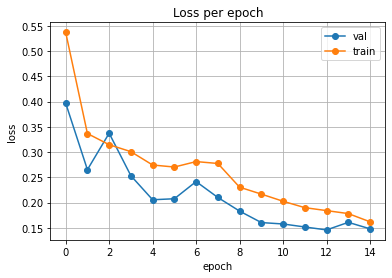

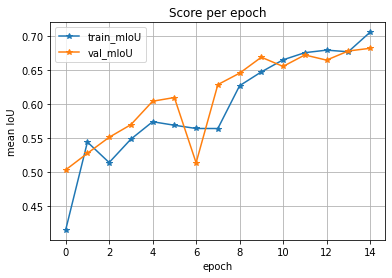

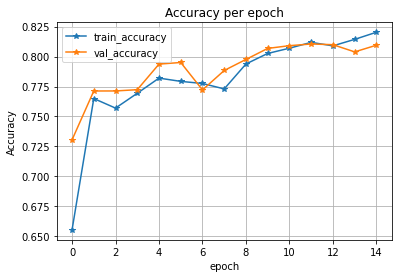

In [39]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [40]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [41]:
xb, yb = next(iter(test_dl))

with torch.no_grad():
    #predb = unet(xb.cuda())
    predb = model(xb.cuda())

predb.shape

torch.Size([12, 2, 512, 512])

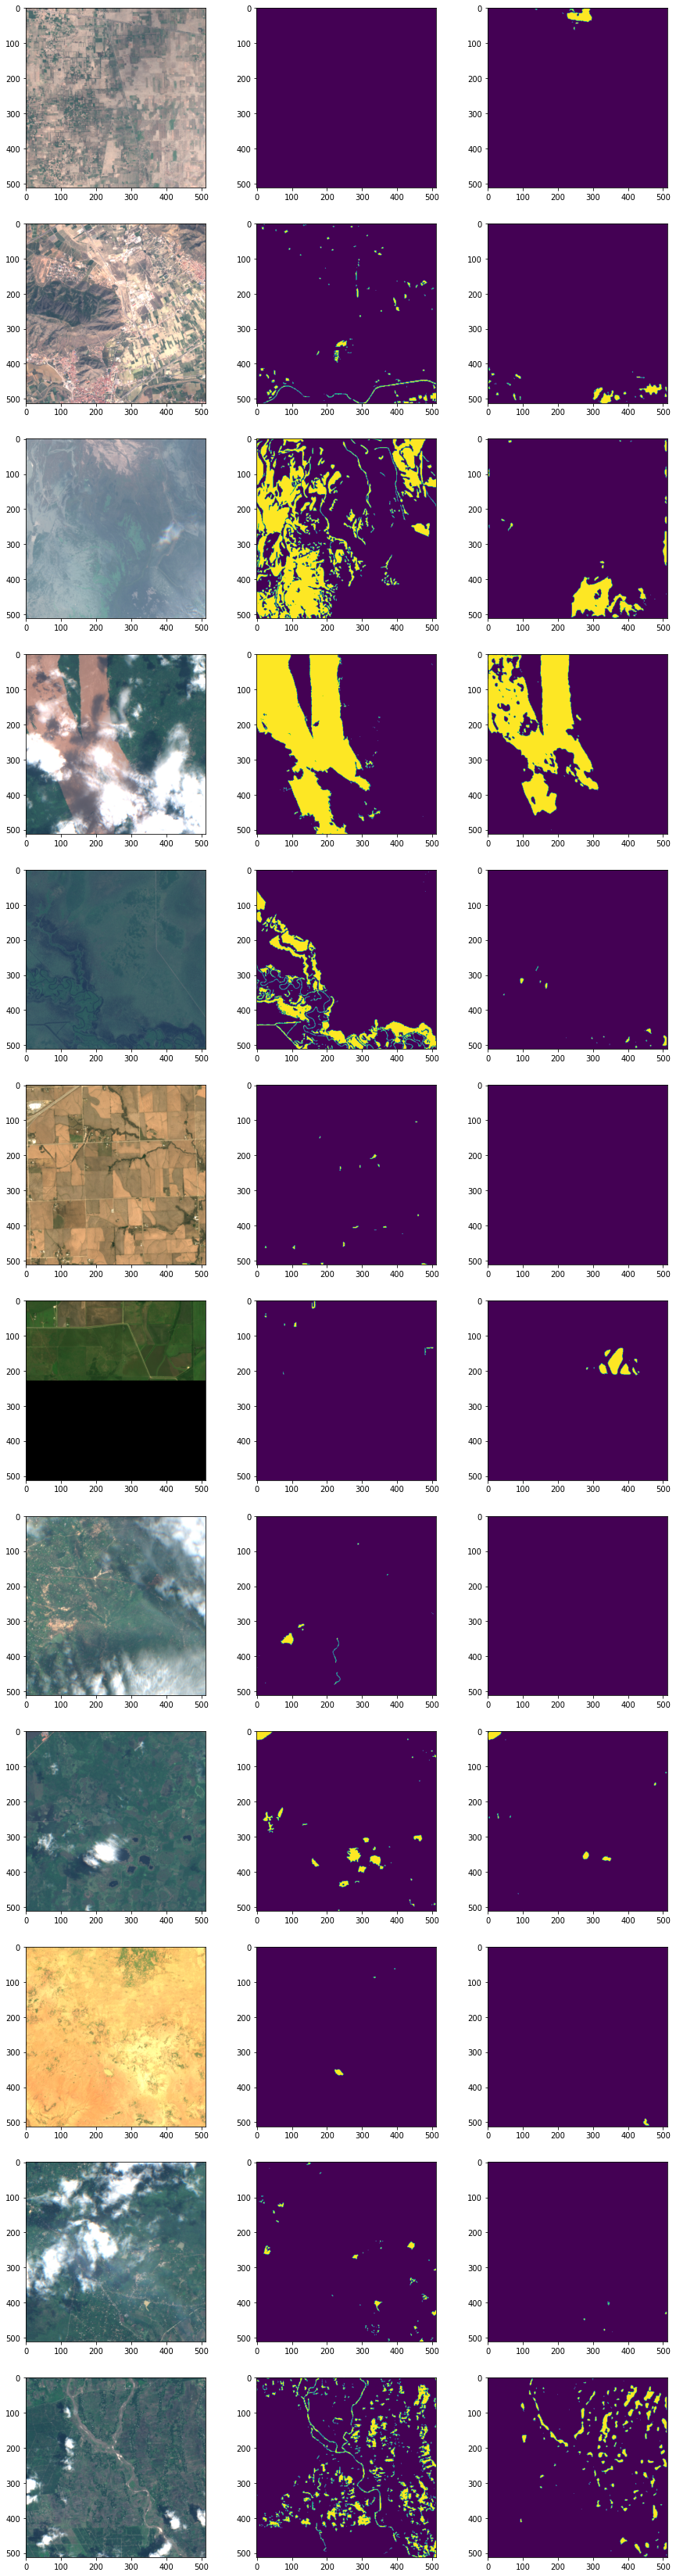

In [46]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))
